### 事前準備

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp "/content/drive/My Drive/Tokyo_Power_weather_2017-2018_sample_new2.csv" "./"   # データのコピー
!cp "/content/drive/My Drive/Tokyo_Power_weather_Predict_sample_new2.csv" "./"
!cp "/content/drive/My Drive/Tokyo_Power_20190401_05.csv" "./"
!ls -l

total 588
drwx------ 4 root root   4096 Aug 20 06:23 drive
drwxr-xr-x 1 root root   4096 Jul 30 16:30 sample_data
-rw------- 1 root root   2114 Aug 20 06:23 Tokyo_Power_20190401_05.csv
-rw------- 1 root root 583152 Aug 20 06:23 Tokyo_Power_weather_2017-2018_sample_new2.csv
-rw------- 1 root root   3140 Aug 20 06:23 Tokyo_Power_weather_Predict_sample_new2.csv


# **scikit-learn(sklearn)で東京電力の電力需要を重回帰予測する例**

### 本例で用いる学習データの所在

*   **東京電力「過去の電力使用実績のダウンロード」**[ここから入手](http://www.tepco.co.jp/forecast/html/download-j.html)
*   **気象庁「過去の気象データ・ダウンロード」**[ここから入手](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)


## **データ準備**

**学習データの準備**

<font color=red>**本例では2017/1/1～2018/12/31の東京電力_電力実績と気象庁データ(気温/降水量/日照時間/風速など)の結合データ(CSV)を使用**</font>

　データフレーム名　**train_df** ：Tokyo_Power_Weather_2017-2018_sample_new2.csvをPandasで格納<br>
　※Pandas：Pythonで表形式のデータを扱うためのライブラリ。データ抽出/加工/集計など、分析でよく使われる。

In [ ]:
import pandas as pd #pandasをpdとしてインポート。データをdfに読み込み。pandasをpdとして利用。
train_df = pd.read_csv("Tokyo_Power_weather_2017-2018_sample_new2.csv", encoding="utf_8")
train_df.head(5)    #データフレームの表示（先頭5行表示）

,DATE,TIME_hh,TIME_mm,Man_kW,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,2017/1/1,1,0,2634,5.1,0.0,3.5,0.0
1,2017/1/1,2,0,2520,4.1,0.0,1.7,0.0
2,2017/1/1,3,0,2438,4.0,0.0,1.5,0.0
3,2017/1/1,4,0,2389,3.0,0.0,1.0,0.0
4,2017/1/1,5,0,2394,3.6,0.0,2.2,0.0


＜参考＞データサンプルのカラム説明（レコード数は17,506） \\
**DATE**:年月日(東電)、**TIME_hh**:時間(東電)、**TIME_mm**:分(東電)、<font color=red>**Man_kW**:電力量　万キロワット(東電)**←今回の目的変数**</font>、 \\
**Temp_C**:気温　℃(気象庁)、**Sun_h**:日照時間　時間(気象庁)、**Wind_m_par_S**:風速　m/秒(気象庁)、**Rain_mm**:降水量　mm(気象庁)


**データの準備** \\
説明変数となるデータ（Ｘ）を準備する。 \\
データフレームから、説明変数で不要なカラム（今回はDATEとTIME_mm）を削除する。   \\
あわせて、目的変数となるカラム（今回はMan_kW）も削除する。

In [ ]:
train_df = train_df.drop("DATE",axis=1)     # 説明変数の不要カラム（DATE）を削除
train_df = train_df.drop("TIME_mm",axis=1)  # 説明変数の不要カラム（TIME_mm）を削除
train_df = train_df.drop("Man_kW",axis=1)   # 目的変数のカラム（Man_kW）を削除
train_df.head(5)    #不要カラム削除後のデータフレーム表示（先頭5行表示）

,TIME_hh,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,1,5.1,0.0,3.5,0.0
1,2,4.1,0.0,1.7,0.0
2,3,4.0,0.0,1.5,0.0
3,4,3.0,0.0,1.0,0.0
4,5,3.6,0.0,2.2,0.0


**説明変数（Ｘ）をセット** \\
上記のデータフレームを入力として、説明変数（Ｘ）をセットする。 \\
ついでに、基本統計量（即ち、Xの概略）も表示する。

In [ ]:
X = train_df   # 説明変数Ｘの準備
print(X.describe())   # Ｘの概要（基本統計量）

            TIME_hh        Temp_C         Sun_h  Wind_m_par_S       Rain_mm
count  17506.000000  17506.000000  17506.000000  17506.000000  17506.000000
mean      11.503713     16.349360      0.237770      2.918565      0.164258
std        6.923247      8.477713      0.389792      1.507695      0.912790
min        0.000000     -3.600000      0.000000      0.000000      0.000000
25%        6.000000      9.000000      0.000000      1.800000      0.000000
50%       12.000000     16.700000      0.000000      2.600000      0.000000
75%       18.000000     23.100000      0.400000      3.700000      0.000000
max       23.000000     37.400000      1.000000     15.300000     20.500000


＜補足＞</br>
describe関数で数値の特徴（基本統計量）を見ることができる。主な項目は次の通り。</br>
<ul>
<li>count：データの個数</li>
<li>mean：平均値</li>
<li>std：標準偏差（データのばらつき）</li>
<li>min/25%/50%/75%/max：四分位(しぶんい)数　全データをソートした後の代表的な数値を抽出した値。より詳細にデータのバラツキが分かる。</li>
</ul>


**説明変数（Ｘ）の確認**

In [ ]:
X.head(5)  # Ｘの表示（先頭5行）

,TIME_hh,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,1,5.1,0.0,3.5,0.0
1,2,4.1,0.0,1.7,0.0
2,3,4.0,0.0,1.5,0.0
3,4,3.0,0.0,1.0,0.0
4,5,3.6,0.0,2.2,0.0


**目的変数（Ｙ）の準備と確認** \\
不要なカラムを削除して、目的変数（今回は電力量Man_kW）をセット。

In [ ]:
train_df = pd.read_csv("Tokyo_Power_weather_2017-2018_sample_new2.csv", encoding="utf_8")
Y = train_df    # 元のtrain.dfからMan_kW以外を削除
Y = Y.drop("DATE",axis=1)
Y = Y.drop("TIME_hh",axis=1)
Y = Y.drop("TIME_mm",axis=1)
Y = Y.drop("Temp_C",axis=1)
Y = Y.drop("Sun_h",axis=1)
Y = Y.drop("Wind_m_par_S",axis=1)
Y = Y.drop("Rain_mm",axis=1)
Y.head(5)   # Ｙの表示（先頭5行）

,Man_kW
0,2634
1,2520
2,2438
3,2389
4,2394


ここまでで、学習データ（テスト含む）となる、Ｘ(説明変数)とＹ(目的変数)の準備が完了。

## **重回帰モデルの作成**

In [ ]:
import pandas as pd    # 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split   # 学習とテストのデータを分割する時に必要
from sklearn import datasets
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 学習用とテスト用のデータ分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=0)   # 学習用80％、テスト用20％に分割

# 重回帰分析（予測モデルの作成）
clf = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=1)
clf.fit(X_train, Y_train)

#print(pd.DataFrame({"Name":X.columns,"Coefficients":np.abs(clf.coef_)}).sort_values(by='Coefficients'))
print("回帰変数：",clf.coef_)    # coef　：回帰変数
print("切片：",clf.intercept_)    # intercept_ ：切片
#print("決定係数(学習用)：",clf.score(X_train,Y_train))   # score ：決定係数 R2を出力
#print("決定係数(テスト用)：",clf.score(X_test,Y_test))   # score ：決定係数 R2を出力

回帰変数： [[ 41.68111068  -4.81237872 440.17305855  36.94520187 -11.17360726]]
切片： [2694.84862232]


**重回帰モデルの作成完了** \\
結果を式で表すと \\
Man_kW =  (41.68×TIME_hh) + (-4.81×Temp_C) + (440.17×Sun_h) + (36.94×Wind_m_par_S) +(-11.17×Rain_mm) +2694.84  \\
となる。

## **予測（Prediction）**

**予測データの準備** \\

<font color=red>**本例では2019/4/1～4/5の東京電力_電力実績と気象庁データ(気温/降水量/日照時間/風速など)の結合データ(CSV)を、将来データとして使用している。**</font>

　データフレーム名　**pred_df** ：Tokyo_Power_weather_Predict_sample_new2.csvをPandasで格納

**データのロード**

In [ ]:
pred_df = pd.read_csv("Tokyo_Power_weather_Predict_sample_new2.csv", encoding="utf_8")   # 予測用データの準備
pred_df.head(5)    #  データフレームの表示（先頭5行）

,DATE,TIME_hh,TIME_mm,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,2019/4/1,1,0,8.2,0.0,3.3,0.0
1,2019/4/1,2,0,7.8,0.0,4.1,0.0
2,2019/4/1,3,0,7.3,0.0,2.4,0.0
3,2019/4/1,4,0,7.1,0.0,4.1,0.0
4,2019/4/1,5,0,6.7,0.0,1.8,0.0


**予測データの準備** \\
データフレームから不要なカラム（今回はDATEとTIME_mm）を削除する。確認のために、先頭データを表示する。

In [ ]:
X2 = pred_df
X2 = X2.drop("DATE",axis=1)
X2 = X2.drop("TIME_mm",axis=1)
X2.head(5)    #不要カラム削除後のデータフレーム表示（先頭5行表示）

,TIME_hh,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,1,8.2,0.0,3.3,0.0
1,2,7.8,0.0,4.1,0.0
2,3,7.3,0.0,2.4,0.0
3,4,7.1,0.0,4.1,0.0
4,5,6.7,0.0,1.8,0.0


**重回帰モデルを使って予測する**  \\
作成した重回帰モデルを使って、電力を予測する。 \\
時間、気温、日照時間、風速、降水量を入力（説明変数Ｘ）として、電力量（目的変数Ｙ）を重回帰モデルで出力する。

In [ ]:
pred = pred_df
rslt = clf.predict(X2)  # 重回帰予測値(目的変数 Y)を取得
pred['Pred_Man_kW'] = np.array(rslt)  # 予測基データ(説明変数 X)のデータフレームに、重回帰予測値(目的変数 Y)をカラム追加
pred.head(10)   # 予測結果を表示（先頭10件）

,DATE,TIME_hh,TIME_mm,Temp_C,Sun_h,Wind_m_par_S,Rain_mm,Pred_Man_kW
0,2019/4/1,1,0,8.2,0.0,3.3,0.0,2818.987394
1,2019/4/1,2,0,7.8,0.0,4.1,0.0,2892.149617
2,2019/4/1,3,0,7.3,0.0,2.4,0.0,2873.430074
3,2019/4/1,4,0,7.1,0.0,4.1,0.0,2978.880504
4,2019/4/1,5,0,6.7,0.0,1.8,0.0,2937.512602
5,2019/4/1,6,0,6.6,0.3,3.4,0.0,3170.839191
6,2019/4/1,7,0,8.0,1.0,2.3,0.0,3473.264390
7,2019/4/1,8,0,8.7,0.7,4.7,0.0,3468.193403
8,2019/4/1,9,0,11.0,0.8,2.4,0.0,3457.849384
9,2019/4/1,10,0,13.2,1.0,2.2,0.0,3569.588833


【参考】カラム説明 

**DATE**:年月日、**TIME_hh**:時間、**TIME_mm**:分、**Temp_C**:気温 ℃、**Sun_h**:日照時間 時間、

**Wind_m_par_S**:風速 m/秒、**Rain_mm**:降水量 mm、

**Pred_Man_kW**:電力量 万キロワット**←今回の目的変数**


**＜参考＞予測した電力量の推移をグラフで表示する**

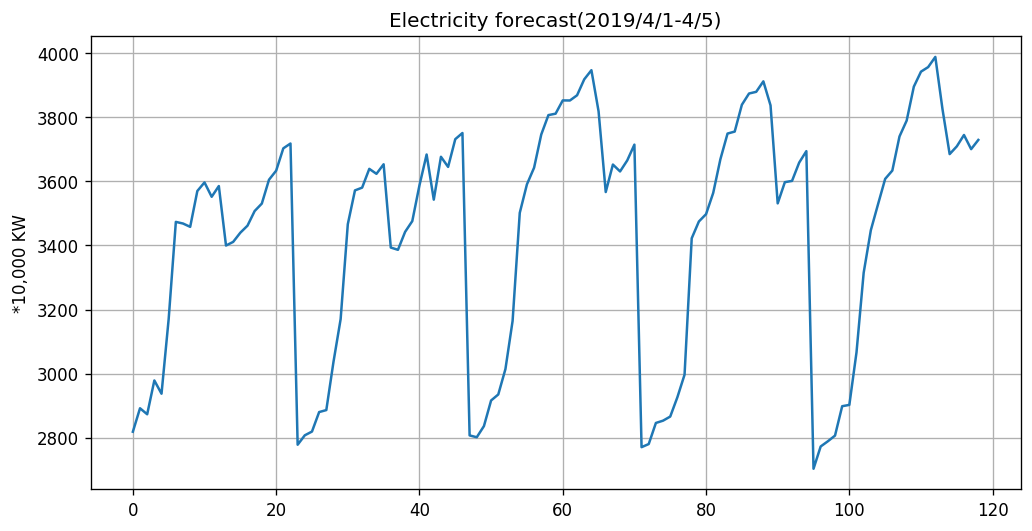

In [ ]:
import matplotlib.pyplot as plt
y = np.array(rslt)  # 電力予測値をYにセット
x = np.array(range(119))  # X用に119個までの連番生成（とりあえず表示するだけなので）
plt.figure(figsize=(10,5),dpi=120)
plt.plot(x,y)
plt.grid(True)
plt.title("Electricity forecast(2019/4/1-4/5)")
plt.ylabel("*10,000 KW")
plt.show()

## **予測電力量と実際の電力量のグラフ比較**
* **<font color=blue>Pred_Man_kW　:今回予測した電力量</font>**
* **<font color=orange>Man_kW　：実際の電力使用量</font>**

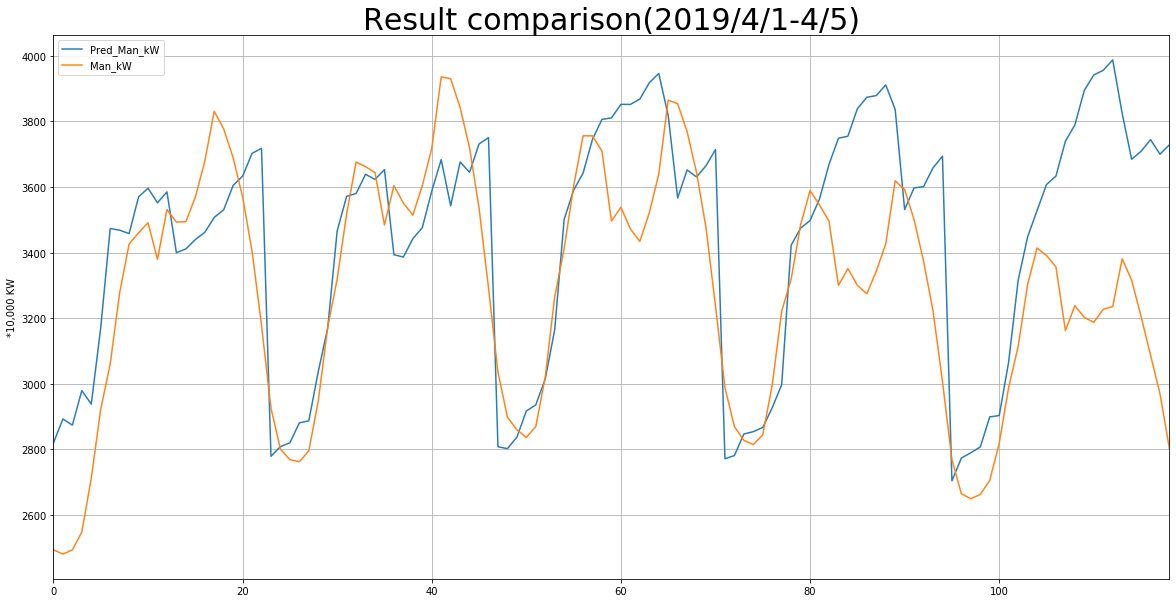

In [ ]:
real_kw_df = pd.read_csv("Tokyo_Power_20190401_05.csv", encoding="utf_8")   # 2019/4/1-4/5の実測値（予測値との比較用）
real_kw_df = real_kw_df.drop("DATE",axis=1)  # 不要カラム削除
real_kw_df = real_kw_df.drop("TIME_hh",axis=1)  # 不要カラム削除
comp_df = pred_df   #  予測結果をセット
comp_df = pd.concat([comp_df, real_kw_df], axis=1)    # 予測結果に実績カラムを追加
#comp_df.head(5)

comp_df.plot(y=['Pred_Man_kW', 'Man_kW'], alpha=12.0, figsize=(20,10))
plt.title("Result comparison(2019/4/1-4/5)", size=30)
plt.grid(True)
plt.ylabel("*10,000 KW")
plt.show()

In [ ]:
pred.to_csv("Tokyo_Power_Prediction_result.csv.csv")   # CSV出力

**重回帰予測とCSV保存が完了。**

### （その他）メモ書きなど

---